# **Respiratory Sound Classification For COVID-19 Preliminary Screening**

**Importing The Necessary Libraries**

Firstly, we need to import the necessary libraries for each of the methods

In [ ]:
# Load various miscillaneous imports
import pandas as pd
import seaborn as sns
import sys
import os
%pip install scikit-plot
import scikitplot as skplt
import librosa  #Comment this if you don't generate features.
from librosa import display
from datetime import datetime
import pickle
import time
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib import cm
from scipy import signal
from google.colab import files

#Import all necessary sci-kit learn libraries for LabelPowerset, Classifier Chain methods
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, jaccard_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import MultinomialNB

%pip install scikit-multilearn
from skmultilearn.problem_transform import LabelPowerset

#Import all necessary tensorflow libraries for CNN, LSTM
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input, Dropout, Activation, Flatten, Embedding, LSTM, TimeDistributed, MaxPooling1D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling1D, Convolution2D, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

#Import BP-MLL loss 
%pip install bpmll
from bpmll import bp_mll_loss


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Next, we need too import the necessary external files for data preperation. If we are using a pre-established set of MFCC features, the files include:

1.   Dataset Metadata File Names
2.   Dataset Classes File Names

1.   MFCC Feature Set

If we are developing our own MFCC features, exclude 3. from the upload






In [ ]:
files.upload()

Saving feature_data_c_w_bothcw_p_h.txt to feature_data_c_w_bothcw_p_h.txt
Saving class_label_c_w_bothcw_p_h.txt to class_label_c_w_bothcw_p_h.txt
Saving c_w_bothcw_p_h.csv to c_w_bothcw_p_h.csv


The purpose of this function is to extract all of the features from the file in question

The librosa library loads the file in question using the resampling type as the maximum quality

Next, we extract the features from the audio sample using the librosa featuresmfcc library. MFCC stands for Mel-Frequency Cepstral Coefficients. These coeffecients are values that collectively create  the **mel-frequency cepstrum **

MFC are a short-term sample of the power levels of a sound. It is based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. This scale was created in order to perveive equivalent distance between sound frequencies, regardless of the value. This helps us distinguish frequencies that humans percevie to be unnoticable in the lower end of the spectrum. 

To derive the coefficients (MFCC) of the Mel scale, we conduct the following steps:

1. Take the Fourier transform of a time-series signal using a FFT.
2. Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
3. Take the  natural logs of the powers at each of the mel frequencies.
4. Transform the mel frequencies using the discrete cosine transform to represent a signal.
5. The MFCC are then the amplitudes of the resulting spectrum

The MFCC have a sweet spot for the number of coefficients.










In [1]:
def extract_features(file_name):
    
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

    return mfccs

The metadata shown in the loaded csv below contrains the file names for all of the audio samples that will be used in this experiment.

In [ ]:
# Set the path to the full UrbanSound dataset
fulldatasetpath = '/Users/khosrap/Desktop/audio_and_txt_files' # You don't need this if you don't generate feature from audio.
metadata = pd.read_csv('c_w_bothcw_p_h.csv') # assign csv with respiratory file names as the metadata

In [ ]:
df = pd.DataFrame(metadata) # converting the metadata to a pandas datframe
df.head() #quickly visualizing our dataframe

,fold,slice_file_name,classID,class
0,bothcw,bothcw_1_107_3p2_Al_mc_AKGC417L.wav,2,both_crackles_wheezes
1,bothcw,bothcw_1_107_3p2_Pr_mc_AKGC417L.wav,2,both_crackles_wheezes
2,bothcw,bothcw_1_107_3p2_Tc_mc_AKGC417L.wav,2,both_crackles_wheezes
3,bothcw,bothcw_1_110_1p1_Al_sc_Meditron.wav,2,both_crackles_wheezes
4,bothcw,bothcw_1_112_1b1_Lr_sc_Meditron.wav,2,both_crackles_wheezes


## *Optional* Generating MFCC Features

The block below will generate the MFCC features if they have not been imported and will load them if they have been imported

In [ ]:
fea_generation_Flag = False # To generate features set fea_generation_Flag as True OR reload generated features, i.e. set as False.

if fea_generation_Flag:

    print('**Generating MFCC features ... (This may cost minutes. Please wait.)')

    features = []
    feature_data = []
    class_labels =[]

    # Iterate through each sound file from csv and extract the features
    for index, row in metadata.iterrows():

        # the path defined in the block above, make sure this path is correct
        file_name = os.path.join(os.path.abspath(fulldatasetpath), 
                                 str(row["fold"]),
                                 str(row["slice_file_name"]))

        
        class_label = row["classID"] # grabbing the labeled classes of each respiratory sample
        data = extract_features(file_name) #generate the MFCC features for the respective file in question

        feature_data.append(data) # add the MFCCs into the data array
        class_labels.append(class_label) # add the class_labels to its corresponding array

        features.append([data, class_label]) # combining the two arrays into features array

    with open("feature_data_c_w_bothcw_p_h.txt", "wb") as fp: # save MFCCs[40,max_pad_len=174]
        pickle.dump(feature_data, fp)

    with open("class_label_c_w_bothcw_p_h.txt", "wb") as fp:  # save labels
        pickle.dump(class_labels, fp)

    # Convert into a panda dataframe
    featuresdf = pd.DataFrame(features, columns=['feature', 'class_label'])

    print('Finished feature extraction from ', len(featuresdf), ' files')
    # Convert features and corresponding classification labels into numpy arrays
    X = np.array(featuresdf.feature.tolist())  # Shape: [8732, 40, 174]
    y = np.array(featuresdf.class_label.tolist())  # Shape: [8732,]

#case if the MFCC features are imported
else:

    print('**Loading .txt MFCC features ...')

    #set the features as the x value
    with open('feature_data_c_w_bothcw_p_h.txt', 'rb') as f:
        x = pickle.load(f)
        X = np.array(x)

    #set the class labels as the y value
    with open('class_label_c_w_bothcw_p_h.txt', 'rb') as f:
        y = pickle.load(f)
        y = np.array(y)

**Loading .txt MFCC features ...


# **Classifier Chains**

For classifier chains, we will be using an ensemble of classifier chains to represent the loaded MFCCs. For this method we will be using a base Logisitic Regression classifier with an overall OneVsRestClassifier

In [ ]:
le = LabelEncoder() # Encode the classification labels
yy = to_categorical(le.fit_transform(y)) # Convert labels to catagorical labels
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Classifier Chains Function Definition

In [ ]:
def classifier_chains(feature_train, y_train, feature_test, y_test):

    base_lr = LogisticRegression() # base classifier
    ovr = OneVsRestClassifier(base_lr) # overall classifier
    ovr.fit(feature_train, y_train)
    Y_pred_ovr = ovr.predict(feature_test)
    ovr_jaccard_score = jaccard_score(y_test, Y_pred_ovr, average='samples') #applying a Jaccard score

    # Fit an ensemble of logistic regression classifier chains and take the
    # take the average prediction of all the chains.
    chains = [ClassifierChain(base_lr, order='random', random_state=i)
              for i in range(10)]
    for chain in chains:
        chain.fit(feature_train, y_train)

    Y_pred_chains = np.array([chain.predict(feature_test) for chain in chains])
    chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5, average='samples')
                            for Y_pred_chain in Y_pred_chains]

    Y_pred_ensemble = Y_pred_chains.mean(axis=0)
    ensemble_jaccard_score = jaccard_score(y_test,
                                           Y_pred_ensemble >= .5,
                                           average='samples')

    model_scores = [ovr_jaccard_score] + chain_jaccard_scores
    model_scores.append(ensemble_jaccard_score)
    model_names = ('Independent', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4', 'Chain 5',
                   'Chain 6', 'Chain 7', 'Chain 8', 'Chain 9', 'Chain 10','Ensemble')

    x_pos = np.arange(len(model_names))

    # Plot the Jaccard similarity scores for the independent model, each of the
    # chains, and the ensemble (note that the vertical axis on this plot does
    # not begin at 0).
    classification_report(y_test, model_scores, target_names = ['crackles','wheezes','bothcw','pneumoniaNoCW','healthyNoCW'])
    print("Classification accuracy:", model_scores)
    print("Average accuracy:", np.average(model_scores[1:-2]))

In [ ]:
classifier_chains(x_train, y_train, x_test, y_test) # creating the classification report for Classifier Chain method

ValueError: ignored

Next we want to encode the classification labels, so that we can transform them into numerical values to feed through our neural network 

In [ ]:
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
'''
    Mutually exclusive categories classification (multi-class):
        one-hot encoding, last-layer with softmax, categorical_crossentropy loss;
        validation metric: accuracy.
    Multi-label categories classification (multi-label):
        multi-label encoding, last-layer with sigmoid, binary_crossentropy loss;
        validation metric: categorical accuracy.
'''

#transforming the multi-class labels to a multi-label scenario for the "bothCW" label
if True:
    for i in range(len(yy)):
        # if both crackles and wheezes are present
        if y[i] == 2:
            yy[i] = [1, 1, 0, 0, 0] 

# split the dataset
y = label_binarize(y,classes=['crackles','wheezes','bothcw','pneumoniaNoCW','healthyNoCW'])
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.20, random_state = 42)


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Checking the shapes of our split dataset

In [ ]:
print("x_train shape is {}".format(x_train.shape))
print("x_test shape is {}".format(x_test.shape))

print("where the dimensions of the input are as follows: (sample, feature, timestamp)")

print("y_train shape is {}".format(y_train.shape))
print("y_test shape is {}".format(y_test.shape))

print("where the dimensions of the output are as follows: (sample, label)")



x_train shape is (3039, 40, 400)
x_test shape is (760, 40, 400)
where the dimensions of the input are as follows: (sample, feature, timestamp)
y_train shape is (3039, 5)
y_test shape is (760, 5)
where the dimensions of the output are as follows: (sample, label)


In [ ]:
num_rows = 40 # assigning a number of MFCC features as our x shape
num_columns = max_pad_len # assigning the length of each MFCC feature as our quantity of columns (max pad length set to 174)
num_channels = 1 # number of channels (only necessary for CNN and LSTM)

# reshaping the MFCC feature data, both training and testing before using them in models
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels) #(6985, 40, 174, 1)-->(6985, 40, 174, 1)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)



# **Random Forest Classifier**

In [ ]:
# averaging the time-axis for training and testing dataset to be used for the Random Forest Classifier
x_train = np.average(x_train, axis=2)
x_test = np.average(x_test, axis=2)

In [ ]:
#defining our classifier
classifier = LabelPowerset(
RandomForestClassifier(n_estimators=150)
)

# fitting the training data
classifier.fit(x_train, y_train)

# predicting our labels of the test dataset
predictions = classifier.predict(x_test)
probs = classifier.predict_proba(x_test)
labels = ['crackles','wheezes',"bothCW",'pneumoniaNoCW','healthyNoCW']

#creating our classification report
print(classification_report(y_test, predictions, target_names = ['crackles','wheezes','bothcw','pneumoniaNoCW','healthyNoCW']))
print('----------------------------------------------------------')
matrix = multilabel_confusion_matrix(y_test,predictions)
print(matrix)


               precision    recall  f1-score   support

     crackles       0.86      0.92      0.89       483
      wheezes       0.92      0.62      0.74       297
       bothcw       0.00      0.00      0.00         0
pneumoniaNoCW       0.80      0.79      0.80        47
  healthyNoCW       0.85      0.83      0.84        60

    micro avg       0.87      0.81      0.84       887
    macro avg       0.69      0.63      0.65       887
 weighted avg       0.88      0.81      0.83       887
  samples avg       0.87      0.83      0.84       887

----------------------------------------------------------
[[[205  72]
  [ 39 444]]

 [[446  17]
  [112 185]]

 [[760   0]
  [  0   0]]

 [[704   9]
  [ 10  37]]

 [[691   9]
  [ 10  50]]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now we can create a heatmap to represent our confusion matrices for each of the classes that we have in our classification report

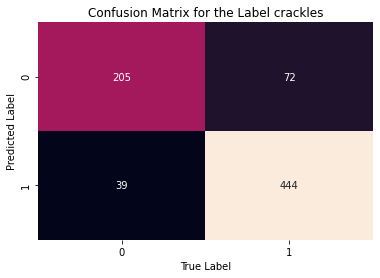

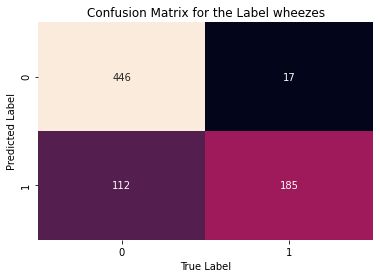

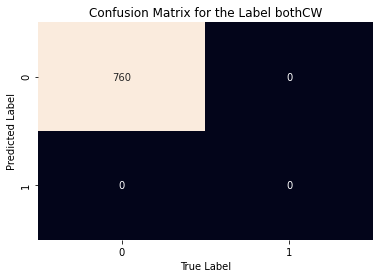

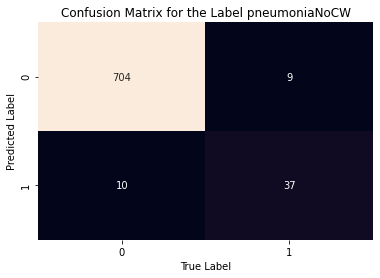

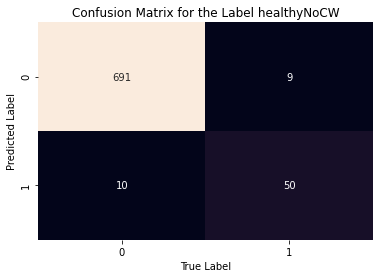

In [ ]:

for i in range(len(matrix)):

  sns.heatmap(matrix[i], annot=True, fmt="d", cbar=False)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title("Confusion Matrix for the Label " + labels[i])
  plt.show()

# **CNN Model**

For this CNN model, we will have the following hyperparameters

1.   optimizer is Adam
2.   loss function is catagorical-crossentropy
3.   number of epochs is 70
4.   batch size is 20



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 39, 399, 32)       160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 19, 199, 32)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 19, 199, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 18, 198, 64)       8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 99, 64)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 9, 99, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 98, 128)      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

     crackles       0.64      1.00      0.78       483
      wheezes       0.00      0.00      0.00       170
pneumoniaNoCW       0.00      0.00      0.00        47
  healthyNoCW       0.00      0.00      0.00        60

     accuracy                           0.64       760
    macro avg       0.16      0.25      0.19       760
 weighted avg       0.40      0.64      0.49       760

----------------------------------------------------------
[[483   0   0   0]
 [170   0   0   0]
 [ 47   0   0   0]
 [ 60   0   0   0]]


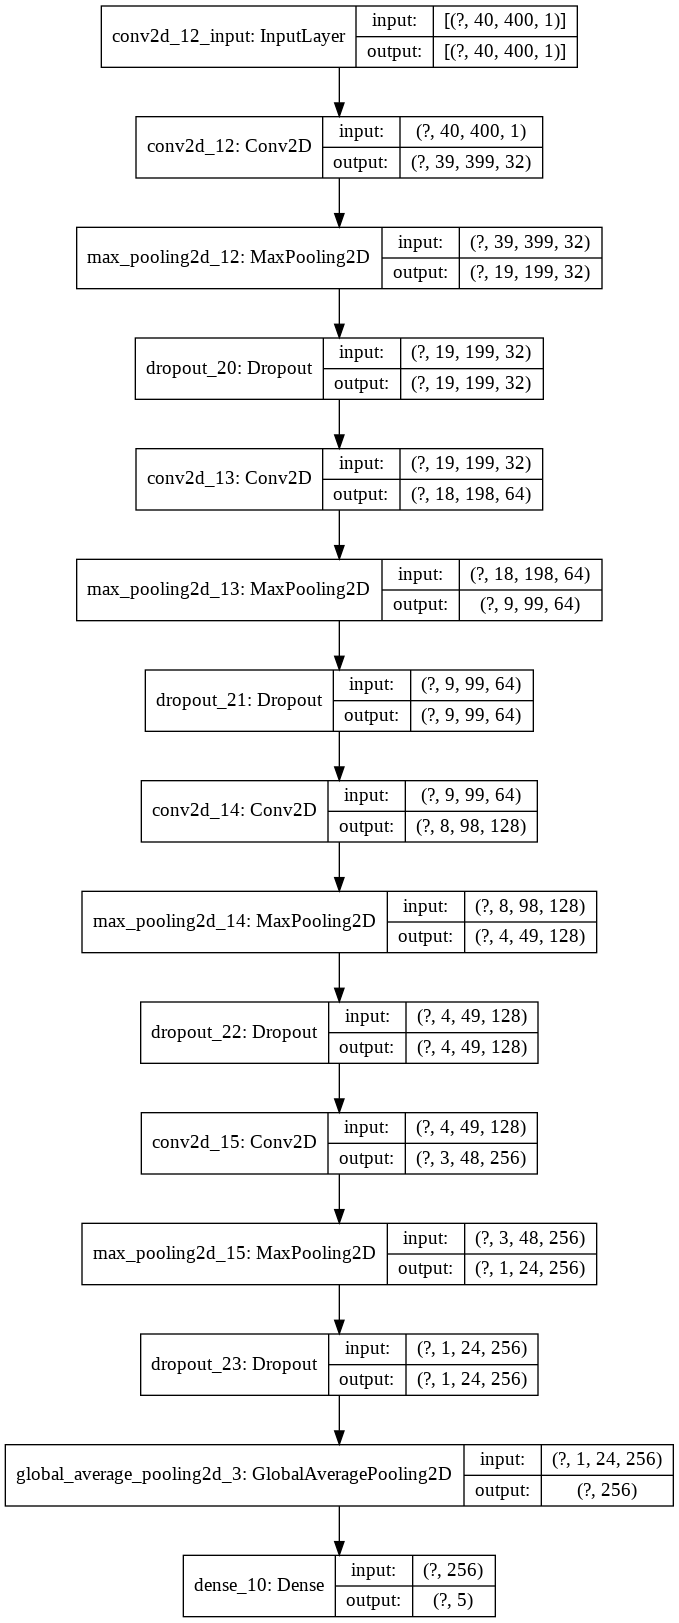

In [ ]:

num_labels = yy.shape[1]

# Construct the model
model = Sequential()
model.add(Conv2D(filters=16*2, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32*2, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64*2, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128*2, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


#compiling the model, set the loss to either "catagorical cross-entropy" or "bp-mll" loss depedning on whether you are classifying the BP-MLL or CNN methods
model.compile(loss=bp_mll_loss, metrics=['accuracy'], optimizer='adam') #optimizer='adam'

# Display model architecture summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names = True)
num_epochs = 70
num_batch_size = 20

stats = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test))

duration = datetime.now() - start
print("Training completed in time: ", duration)
#----------------------------------------------------------------------------------------------#
if False:
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.title('Accuracy')
    plt.plot(stats.history['accuracy'], label = 'training acc')
    plt.plot(stats.history['val_accuracy'], label = 'validation acc')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(stats.history['loss'], label = 'training loss')
    plt.plot(stats.history['val_loss'], label = 'validation loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])
#----------------------------------------------------------------------------------------------#

# F-score, and Confusion matrix
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(y_test, axis = 1)

print(classification_report(labels, predictions, target_names = ['crackles','wheezes','pneumoniaNoCW','healthyNoCW']))
print('----------------------------------------------------------')
print(confusion_matrix(labels, predictions))
plot_model(model, show_shapes=True, show_layer_names = True)


In [ ]:
#printing our accuracy for our model
acc = accuracy_score(y_test, predictions)
print('The accuracy of the model is {accuracy}%'.format(accuracy=acc*100))


The accuracy of the model is 76.84210526315789%
Completed in 3.3674583435058594 seconds


# **LSTM**

For this LSTM structure we define our timesteps and quantity of sequences before we construct our model

In [ ]:
data_dim = x_train.shape[1] # assign the data dimension of a variable
timesteps = x_train.shape[2] # assigning timesteps for the LSTM method
numberofSequence = x_train.shape[0]

### CNN-RNN Model

In [ ]:
def CNN_RNN_model(num_rows,num_columns, timesteps):

    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.00, amsgrad=False)
    model = Sequential()

    # For standalone LSTM model comment out all model steps until the LSTM steps
    # For CNN-LSTM model, CNN model components are converted to a Time-Distributed version
    model.add(TimeDistributed(Conv1D(filters=16*2, kernel_size=2, input_shape=(num_rows, num_columns, num_channels,1), activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv1D(filters=32*2, kernel_size=2, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv1D(filters=64*2, kernel_size=2, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv1D(filters=128*2, kernel_size=2, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(TimeDistributed(GlobalAveragePooling1D()))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(120, return_sequences=True,input_shape=(num_columns,timesteps)))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


Epoch 1/50
31/31 [==============================] - 7s 224ms/step - loss: 1.2329 - accuracy: 0.6104 - val_loss: 1.1925 - val_accuracy: 0.6355
Epoch 2/50
31/31 [==============================] - 6s 188ms/step - loss: 1.1336 - accuracy: 0.6209 - val_loss: 1.1078 - val_accuracy: 0.6368
Epoch 3/50
31/31 [==============================] - 6s 188ms/step - loss: 1.0807 - accuracy: 0.6229 - val_loss: 1.0867 - val_accuracy: 0.6132
Epoch 4/50
31/31 [==============================] - 6s 189ms/step - loss: 1.0667 - accuracy: 0.6252 - val_loss: 1.0855 - val_accuracy: 0.6289
Epoch 5/50
31/31 [==============================] - 6s 189ms/step - loss: 1.0546 - accuracy: 0.6288 - val_loss: 1.0747 - val_accuracy: 0.6382
Epoch 6/50
31/31 [==============================] - 6s 189ms/step - loss: 1.0495 - accuracy: 0.6331 - val_loss: 1.1486 - val_accuracy: 0.6355
Epoch 7/50
31/31 [==============================] - 6s 189ms/step - loss: 1.0600 - accuracy: 0.6265 - val_loss: 1.1131 - val_accuracy: 0.6329
Epoch 

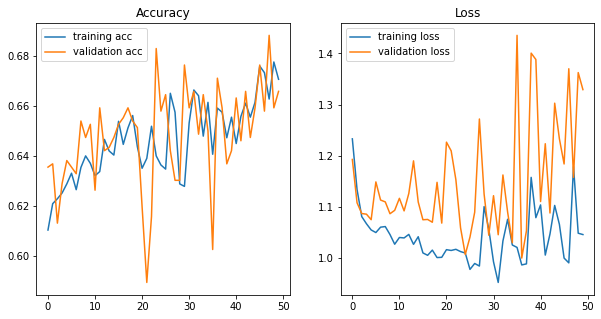

Training Accuracy:  0.6646923422813416
Testing Accuracy:  0.6657894849777222


In [ ]:
model = CNN_RNN_model(num_rows=num_rows,num_columns=num_columns, timesteps=timesteps)
stats = model.fit(x_train, y_train, batch_size=100,epochs=50, validation_data=(x_test, y_test), verbose=1)
model.summary()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['accuracy'], label = 'training acc')
plt.plot(stats.history['val_accuracy'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')
plt.show()
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])


In [ ]:
# F-score, and Confusion matrix
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(y_test, axis = 1)

print(classification_report(labels, predictions, target_names = ['crackles','wheezes','pneumoniaNoCW','healthyNoCW']))
print('----------------------------------------------------------')
print(confusion_matrix(labels, predictions))
print('----------------------------------------')
print('Finished.')

               precision    recall  f1-score   support

     crackles       0.74      0.79      0.77       483
      wheezes       0.48      0.42      0.45       170
pneumoniaNoCW       0.48      0.32      0.38        47
  healthyNoCW       0.58      0.62      0.60        60

     accuracy                           0.67       760
    macro avg       0.57      0.54      0.55       760
 weighted avg       0.65      0.67      0.66       760

----------------------------------------------------------
[[382  77  10  14]
 [ 90  72   4   4]
 [ 21   2  15   9]
 [ 21   0   2  37]]
----------------------------------------
Finished.
